# Disease Classification

In [1]:
from src.scripts.disease_plotting import (
    load_uniprotid_diseases,
    quantify_missing_diseases,
    add_keywords_when_comments_missing,
    sort_diseases,
)
from src.scripts.save_plotly import save_plotly
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import plotly.express as px

import warnings

warnings.filterwarnings("ignore")

In [2]:
bindingdb_df = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=["UniProt (SwissProt) Primary ID of Target Chain", "Article DOI"],
)

We now load the `src/data/UniprotID_disases.json` file which was generated using the following script in roughly 30 mins:

```py
from src.scripts.uniprot import get_uniprot_diseases
import os

get_uniprot_diseases(
    bindingdb_df["UniProt (SwissProt) Primary ID of Target Chain"].value_counts().index,
    savename=os.path.join(
        "src",
        "data",
        "UniprotID_disases.json",
    ),
)
```

The function `get_uniprot_diseases` uses an Uniprot API call to retrieve disease information. An Uniprot ID can be linked to more than one disease.

In [3]:
diseases = load_uniprotid_diseases()
ids_missing_diseases, percentage_missing = quantify_missing_diseases(diseases)
diseases_df = add_keywords_when_comments_missing(diseases)

print(
    f"Percentage of Uniprot IDs missing a disease description : {percentage_missing:.2f}%"
)
print(
    f"One random missing ID: https://www.uniprot.org/uniprotkb/{ids_missing_diseases[42]}"
)

Percentage of Uniprot IDs missing a disease description : 77.14%
One random missing ID: https://www.uniprot.org/uniprotkb/Q9Y5N1


As we observe, 77.14% of Uniprot IDs are missing a description of the related diseases. If we choose a random missing ID (`Q9Y5N1`), we see that on the Uniprot page, under the section `Disease & Variants`, there are no registered diseases.

One problem with using Uniprot's API is that sometimes the related diseases are either under the `keywords` section or the `comments` section. Since the `comments` section is more thorough, we decided to add the `keywords` to our data only if it is missing comments, using the `pandas.DataFrame.bfill` method and illustrated in the next cell.

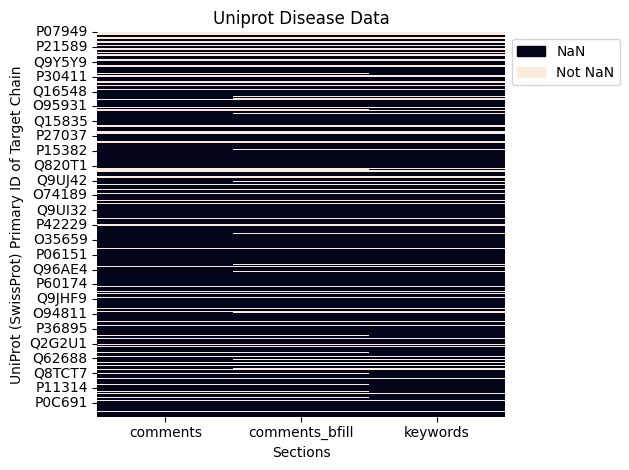

In [4]:
fig, ax = plt.subplots()

cmap = sns.color_palette("rocket", as_cmap=True)

sns.heatmap(
    diseases_df[
        [
            "UniProt (SwissProt) Primary ID of Target Chain",
            "comments",
            "comments_bfill",
            "keywords",
        ]
    ]
    .set_index("UniProt (SwissProt) Primary ID of Target Chain")
    .notna(),
    ax=ax,
    cbar=False,
    cmap=cmap,
)

isna_patch = mpatches.Patch(color=cmap.get_under(), label="NaN")
notna_patch = mpatches.Patch(color=cmap.get_over(), label="Not NaN")

ax.legend(title="", handles=[isna_patch, notna_patch])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Sections")

ax.set_title("Uniprot Disease Data")

plt.tight_layout()
plt.show()

With this data we can now plot the frequency of studied diseases. We group the diseases into different classes using the `sort_diseases` function, based on common names and terminologies. We then show the distribution of targeted diseases.

In [5]:
diseases_df = diseases_df.rename(columns={"comments_bfill": "diseases"})
diseases_df = diseases_df.dropna(subset="diseases").drop(
    columns=["comments", "keywords"]
)
diseases_df["Disease Classes"] = diseases_df["diseases"].apply(
    lambda l: [sort_diseases(l_i) for l_i in l]
)

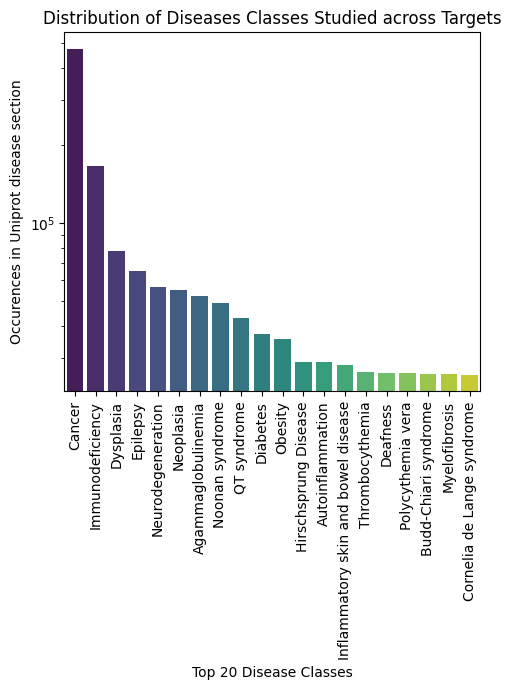

In [6]:
df_intersection_disease_class_counts = (
    bindingdb_df.merge(diseases_df, how="inner")
    .explode(["Disease Classes", "diseases"])
    .value_counts(subset=["Disease Classes"])
    .reset_index()
)

fig, ax = plt.subplots(figsize=(5, 7))

sns.barplot(
    data=df_intersection_disease_class_counts,
    x="Disease Classes",
    y="count",
    order=df_intersection_disease_class_counts["Disease Classes"][:20],
    # hue="count",
    legend=None,
    palette="viridis",
    ax=ax,
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Top 20 " + ax.get_xlabel())
ax.set_yscale("log")
ax.set_ylabel("Occurences in Uniprot disease section")
ax.set_title("Distribution of Diseases Classes Studied across Targets")

plt.tight_layout()
plt.show()

In [7]:
df_intersection_disease_class_counts["Disease Classes"][:20]

df_intersection_disease_class_counts.iloc[20:, 0] = "Other Diseases"
df_intersection_disease_class_counts = (
    df_intersection_disease_class_counts.groupby("Disease Classes")
    .sum()
    .reset_index()
    .sort_values("count", ascending=False)
)
df_intersection_disease_class_counts

,Disease Classes,count
17,Other Diseases,1461285
3,Cancer,474115
10,Immunodeficiency,166166
7,Dysplasia,77498
8,Epilepsy,65101
14,Neurodegeneration,56169
13,Neoplasia,55002
0,Agammaglobulinemia,51927
15,Noonan syndrome,48792
19,QT syndrome,42678


In [8]:
fig = px.pie(
    df_intersection_disease_class_counts,
    values="count",
    names="Disease Classes",
    # template="plotly_dark",
)

# # De-emphasize "Other Diseases"
fig.data[0].pull = [
    0.15 if name == "Other Diseases" else 0
    for name in df_intersection_disease_class_counts["Disease Classes"]
]

fig.update_layout(
    title={
        "text": "Distribution of Disease Classes",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
)

save_plotly(fig, r"./figures/disease_classes")


fig.show()

In [9]:
custom_style = """
<style>
  body, html {
    background-color: rgb(34, 37, 41);
  }
</style>
"""

# Save the HTML file and inject the custom style
html_content = fig.to_html(full_html=True, include_plotlyjs="cdn")
# Insert the style in the <head>
html_content = html_content.replace("</head>", f"{custom_style}</head>")

# Write to a file
with open("disease_classes.html", "w") as f:
    f.write(html_content)

In [10]:
fig.write_image("disease_classes.svg")

In the above plot, we observe that `Cancer`, which regroups all kinds of different cancers, is the most studied disease class. `Neurodegeneration` which regroups diseases such as `Parkinson` and `Alzheimer` is 5th. The sexually transmitted disease of `AIDS` is also within the top 20, recalling its importance in targeted organisms. 

We now load the `src/data/metadata.csv` file which was generated using the following script in roughly 5 hours:

```py
from src.scripts.metadata import add_extra_pub_data
import pandas as pd
df = pd.read_csv(
    r"./data/BindingDB_All.tsv",
    sep="\t",
    usecols=["Article DOI"],
)
add_extra_pub_data(df)
```

This function uses a `crossref` API call to collect additional metadata from publications, such as year, publisher and more.

In [12]:
doi_metadata = pd.read_csv(r"../src/data/metadata.csv").dropna()
doi_metadata.describe(include="all").fillna("")

,Article DOI,journal,year,publisher
count,40719,40719,40719.0,40719
unique,40719,195,,33
top,10.1021/jm9602571,Journal of Medicinal Chemistry,,Elsevier BV
freq,1,13877,,21918
mean,,,2008.964709,
std,,,8.519787,
min,,,1965.0,
25%,,,2004.0,
50%,,,2010.0,
75%,,,2016.0,


From the `crossref` API, we collected the `journal`, the `year` and the `publisher` related to the `Article DOI`. We can see that there are 195 unique journals, and 33 different publishers. With the year, we can now correlate the frequency of diseases studied with time.

In [36]:
time_series_diseases_df = (
    bindingdb_df.dropna()
    .merge(diseases_df.dropna(), how="inner")
    .merge(doi_metadata.dropna(), how="inner")
)

time_series_diseases_df_count = (
    time_series_diseases_df.explode(["Disease Classes", "diseases"])
    .value_counts(subset=["year", "Disease Classes", "diseases"])
    .reset_index()
)
time_series_diseases_df_count["Disease Classes"] = time_series_diseases_df_count[
    "Disease Classes"
].replace(
    {
        k: "Other Diseases"
        for k in time_series_diseases_df.explode(["Disease Classes"])["Disease Classes"]
        .value_counts()
        .index[20:]
    }
)

other_diseases_simplified = (
    time_series_diseases_df_count[
        time_series_diseases_df_count["Disease Classes"] == "Other Diseases"
    ]
    .groupby("year")
    .aggregate({"count": "sum", "diseases": "first", "Disease Classes": "first"})
    .reset_index()
)
other_diseases_simplified["diseases"] = other_diseases_simplified["Disease Classes"]

time_series_diseases_df_count = pd.concat(
    [
        time_series_diseases_df_count.drop(
            index=time_series_diseases_df_count[
                time_series_diseases_df_count["Disease Classes"] == "Other Diseases"
            ].index
        ),
        other_diseases_simplified,
    ],
    axis=0,
)

fig = px.area(
    time_series_diseases_df_count,
    x="year",
    y="count",
    color="Disease Classes",
    line_group="diseases",
    labels={
        "count": "Occurences in Uniprot disease section",
        "year": "Publication Year",
    },
    title="Related disease classes across targets in BindingDB over time",
    template="plotly_dark",
)
fig.for_each_trace(
    lambda t: t.update(visible=True)
    if t["legendgroup"] != "Other Diseases"
    else t.update(visible="legendonly")
)
fig.update_layout(
    plot_bgcolor="rgb(34, 37, 41)",
    paper_bgcolor="rgb(34, 37, 41)",
)
fig.show()  # Uncomment this line to view the figure interactively


# fig.show(
#     renderer="png"
# )  # Low quality rendenring otherwise it slows the notebook too much

# fig.for_each_trace(
#     lambda t: t.update(visible=True)
#     if t["legendgroup"] == "AIDS"
#     else t.update(visible="legendonly")
# )
# fig.show(renderer="svg")

# fig.for_each_trace(
#     lambda t: t.update(visible=True)
#     if t["legendgroup"] == "Cancer"
#     else t.update(visible="legendonly")
# )
# fig.show(renderer="svg")

In [37]:
save_plotly(fig, "./figures/diseases_timeseries")

In the above plots, each line represents a single disease, while shades of colors represent the disease class. By interacting with this plot, we observe that `AIDS` was studied more during the 90's, peaked in 1996, and decreased ever since. This is highly likely due to the 1980s [AIDS pandemic](https://en.wikipedia.org/wiki/Epidemiology_of_HIV/AIDS). On the other hand, proteins related to cancer started to become more popular around 2004, peaked in 2011 where more specifically `Hepatocellular Carcinoma` was the most studied.

If we look at the data as a whole, we can see three peaks above 60k mentions, which are in 2011, in 2016 and in 2019, possibly reflecting the addition of new curations to BindingDB.